# Results for experiments with Co-embeddings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [115]:
import colors

In [151]:
import seaborn
seaborn.set_style('white')
seaborn.set_context("paper", font_scale=2)

In [3]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [4]:
def base_metrics_df():
    return pandas.DataFrame(columns=['Experiment', 'Run',
                                     'AUC-mean', 'RMSE-mean', 'APS-mean', 'Accuracy-mean', 'R2-mean',
                                     'AUC-std', 'RMSE-std', 'APS-std', 'Accuracy-std', 'R2-std'])

In [30]:
def get_not_averaged_metrics(dirnames):
    """Returns the metrics not averaged by student sequence"""
    results = []
    for dirname in reversed(dirnames):
        for filename in get_runs(dirname):
            results.append([dirname.split('/')[-1]])
            # results[-1].append(re.search('.*run(\d+).*', filename).group(1))
            with open(os.path.join(dirname, filename), 'rb') as prediction_file:
                true, predicted = pickle.load(prediction_file)
                if numpy.any(numpy.greater(true[0], 1)):
                    true = numpy.array([numpy.greater_equal(seq, 1).astype(numpy.int32) for seq in true])

            # Flatten the sequences
            true_sequence = numpy.array([x for sequence in true for x in sequence])
            predicted_sequence = numpy.array([x for sequence in predicted for x in sequence])

            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
            results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
            results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
            results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))

    return pandas.DataFrame(results, columns=['Experiment','AUC', 'RMSE', 'Accuracy', 'R2'])

## Learning curves

In [6]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'])
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'])
            train['Dataset'] = 'train'
            validation['Dataset'] = 'validation'
            dataframes.append(pandas.concat([train, validation]))
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        seaborn.factorplot(data=performance_dataframe, x='epoch', y='mse', hue='Dataset',
                           despine=True, ylim=[0, 0.3], aspect=1.5, col_wrap=2, size=3,
                           palette='colorblind')
        plt.show()

In [56]:
def get_overfitting_score(performances):
    overfitting_score = pandas.DataFrame(columns=['OS'])
    for experiment in sorted(performances.keys()):
        performances_df = performances[experiment]
        group = performances_df.loc[performances_df.epoch == performances_df.epoch.max()]
        scores = group[group.Dataset == 'validation'].mse.iloc[0] - group[group.Dataset == 'train'].mse.iloc[0]
        overfitting_score.loc[experiment.split('/')[-1], 'OS'] = scores
    overfitting_score = overfitting_score.reset_index().rename(columns={'index': 'Experiment'})
    overfitting_score['OS'] = pandas.to_numeric(overfitting_score['OS'])
    return overfitting_score

# Experiments with LSTM

In [77]:
LSTM_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-25-18-16',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-25-21-14',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-25-23-18',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-01-37',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-04-09',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-06-40',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-09-40',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-12-10',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-14-44',
]

In [78]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

In [80]:
lstm_overfitting_score = get_overfitting_score(lstm_performances)
lstm_overfitting_score

,Experiment,OS
0,19-05-25-18-16,0.078756
1,19-05-25-21-14,0.058588
2,19-05-25-23-18,0.056317
3,19-05-26-01-37,0.125347
4,19-05-26-04-09,0.116285
5,19-05-26-06-40,0.129570
6,19-05-26-09-40,0.102630
7,19-05-26-12-10,0.097547
8,19-05-26-14-44,0.038506


/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-14-44


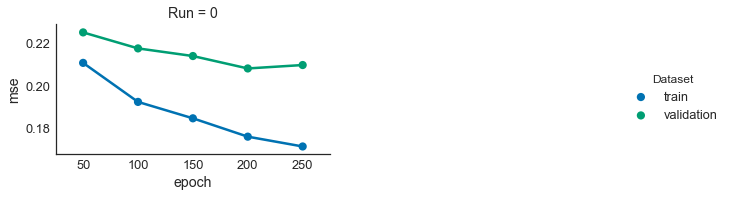

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-25-18-16


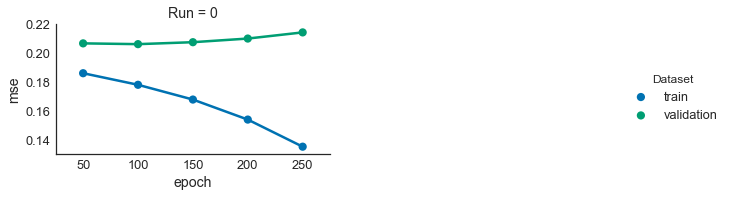

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-25-21-14


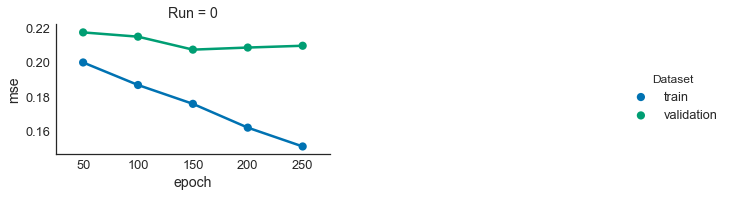

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-06-40


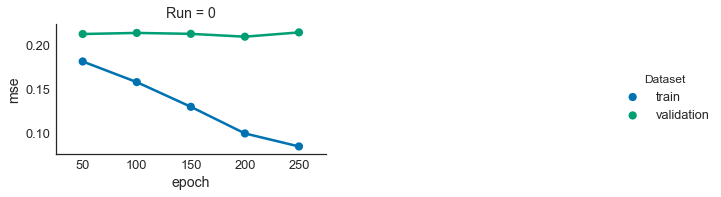

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-04-09


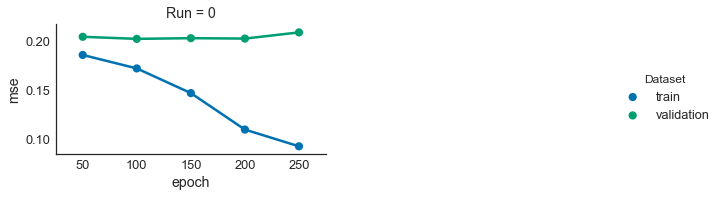

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-12-10


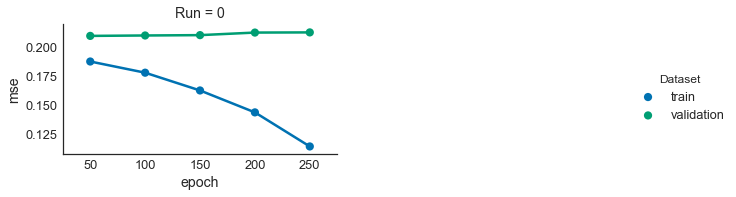

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-25-23-18


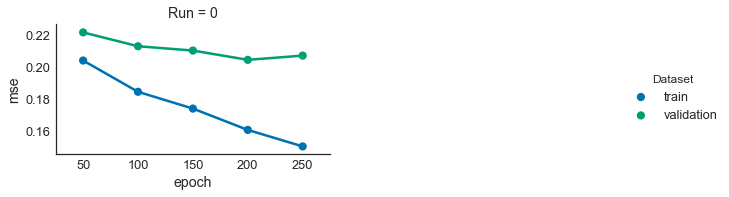

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-09-40


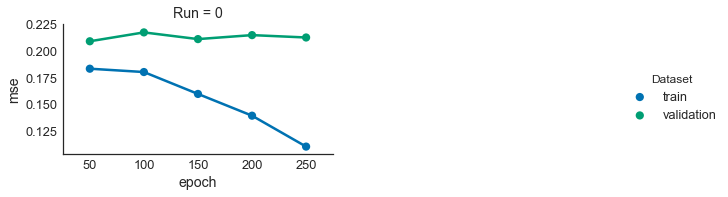

/home/mteruel/edm/results/dkt_lstm/by_problem_id/lstm/19-05-26-01-37


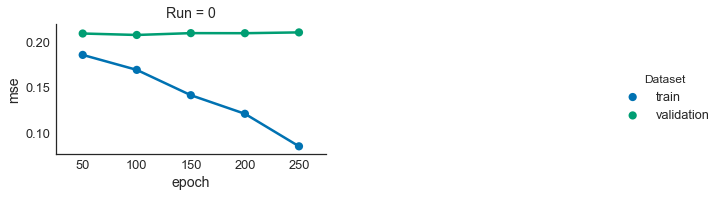

In [82]:
graphic_performances(lstm_performances)

In [126]:
lstm_metrics = get_not_averaged_metrics(LSTM_EXPERIMENTS_DIRS).sort_values('Experiment').merge(lstm_overfitting_score)
lstm_metrics

,Experiment,AUC,RMSE,Accuracy,R2,OS
0,19-05-25-18-16,0.698810,0.460378,0.683587,0.058702,0.078756
1,19-05-25-21-14,0.708487,0.457229,0.681539,0.093017,0.058588
2,19-05-25-23-18,0.706867,0.456682,0.683469,0.087370,0.056317
3,19-05-26-01-37,0.735910,0.448990,0.711678,0.091988,0.125347
4,19-05-26-04-09,0.718522,0.457215,0.693472,0.069265,0.116285
5,19-05-26-06-40,0.709042,0.461779,0.685333,0.061159,0.129570
6,19-05-26-09-40,0.700894,0.466779,0.684777,0.036362,0.102630
7,19-05-26-12-10,0.699729,0.458295,0.684554,0.063180,0.097547
8,19-05-26-14-44,0.694505,0.450345,0.686716,0.079792,0.038506


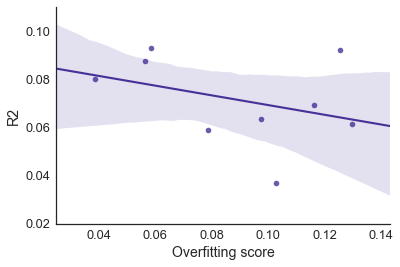

In [127]:
ax = seaborn.regplot(data=lstm_metrics, x='OS', y='R2', color=colors.dark_blue)
ax.set(xlabel='Overfitting score')
seaborn.despine()

# Experiments with EMBEDDINGS

In [187]:
EMBEDDINGS_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-04-54',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-05-10',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-05-21',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-05-35',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-05-53',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-06-03',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-06-12',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-06-21',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-06-47',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-06-56',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-07-05',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-07-27',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-07-35',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-07-44',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-07-54',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-08-04',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-08-15',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-08-25',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-27-08-47',
]

In [188]:
embedding_performances = read_performances(EMBEDDINGS_EXPERIMENTS_DIRS)

In [189]:
embedding_overfitting_score = get_overfitting_score(embedding_performances)
embedding_overfitting_score

,Experiment,OS
0,19-05-27-04-54,0.085400
1,19-05-27-05-10,0.071172
2,19-05-27-05-21,0.087833
3,19-05-27-05-35,0.101029
4,19-05-27-05-53,0.044656
5,19-05-27-06-03,0.061142
6,19-05-27-06-12,0.050093
7,19-05-27-06-21,0.147789
8,19-05-27-06-47,0.082818
9,19-05-27-06-56,0.064515


/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-11-16


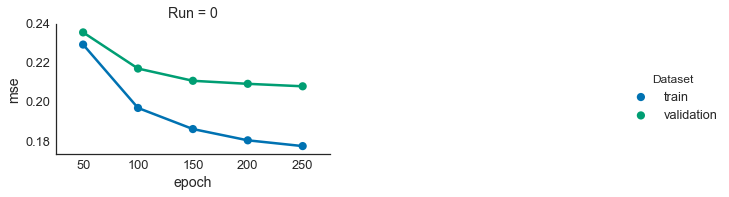

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-13-00


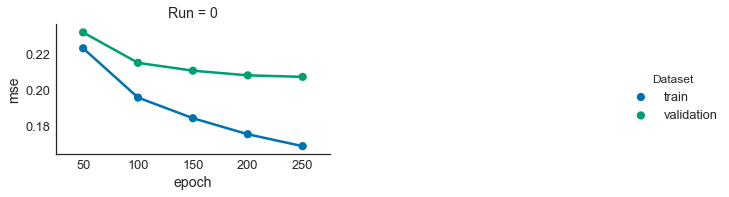

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-13-53


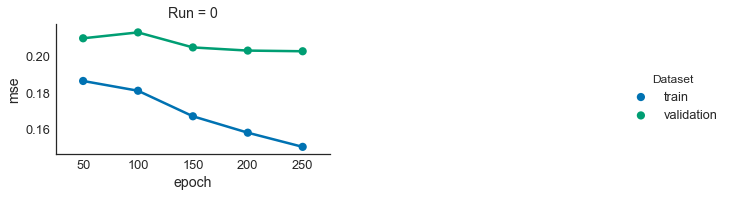

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-14-09


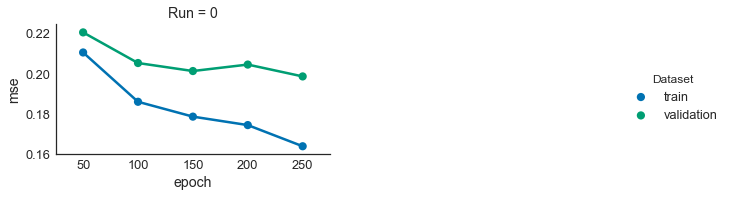

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-14-18


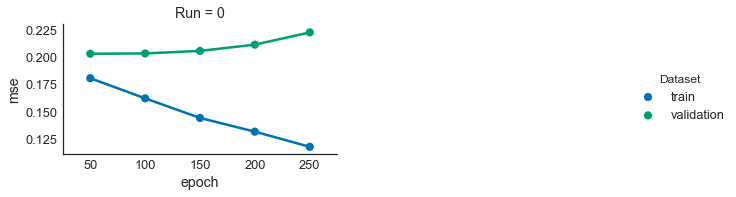

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-12-49


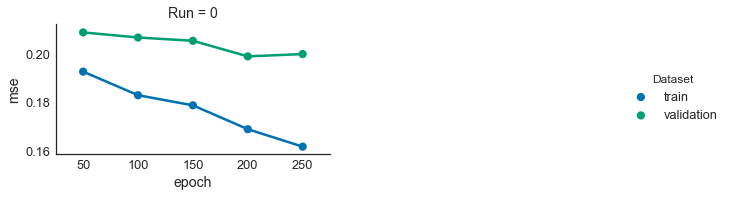

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-12-13


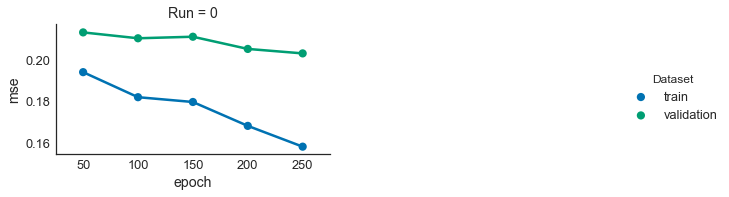

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-10-41


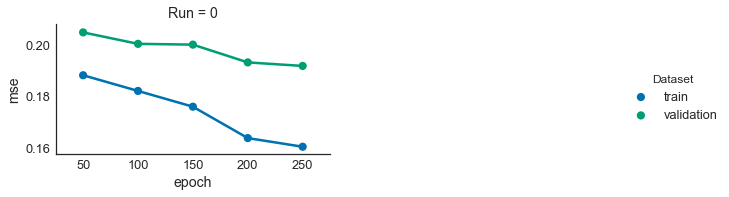

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-12-28


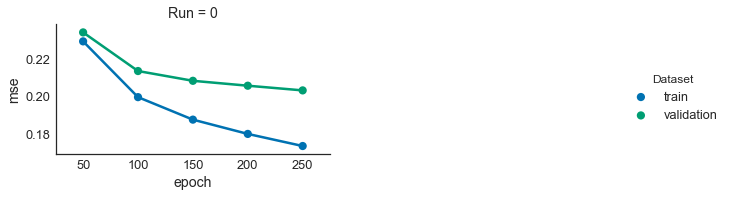

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-13-17


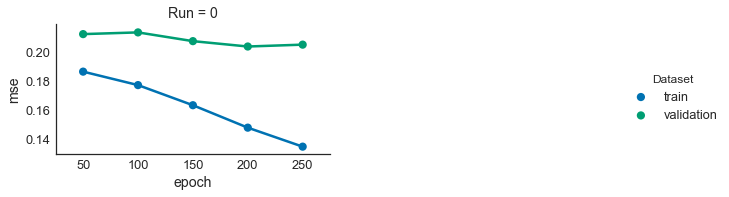

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-10-26


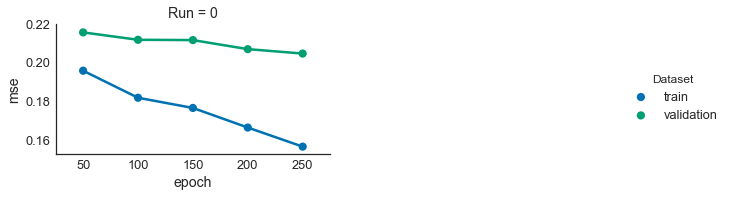

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-14-34


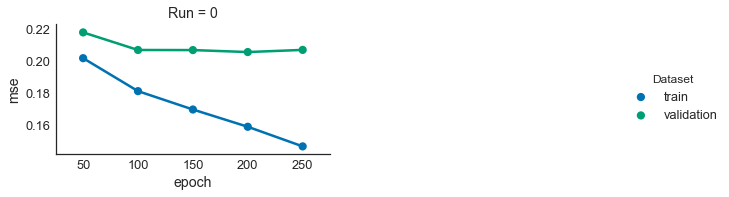

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-13-08


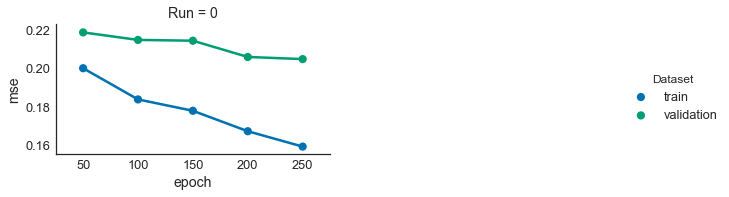

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-11-35


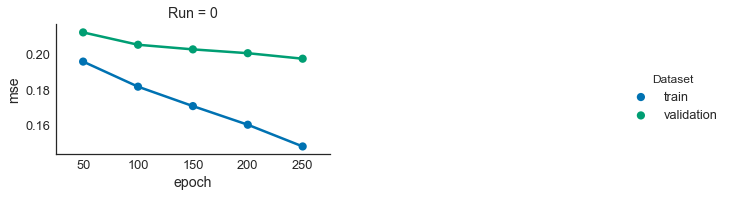

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-11-24


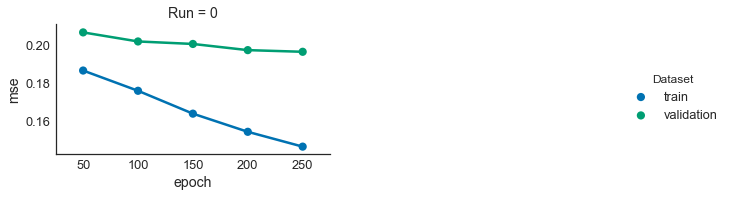

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-12-38


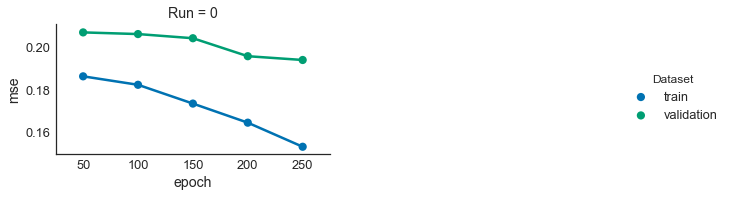

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-10-51


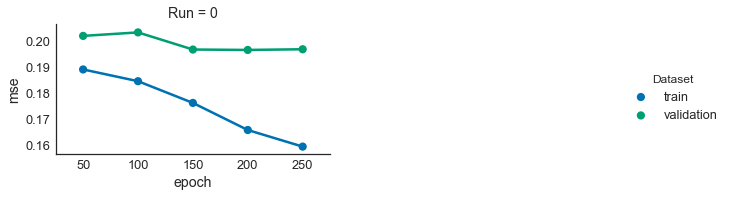

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-11-50


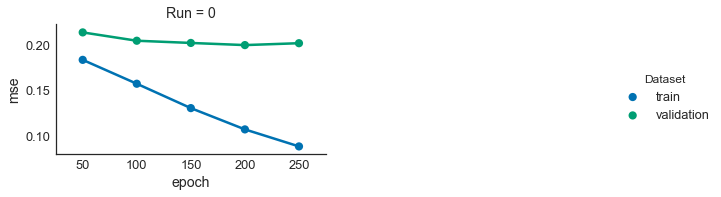

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-11-02


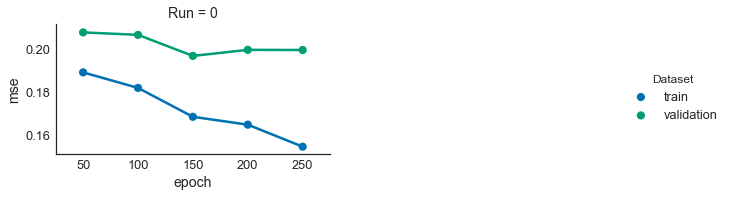

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/19-05-22-13-30


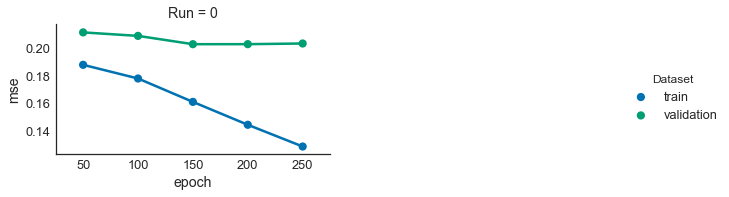

In [66]:
graphic_performances(embedding_performances)

## Performance metrics not averaged by sequence

In [190]:
embedding_not_averaged_results = get_not_averaged_metrics(EMBEDDINGS_EXPERIMENTS_DIRS).merge(
    embedding_overfitting_score).sort_values('Experiment')
embedding_not_averaged_results

,Experiment,AUC,RMSE,Accuracy,R2,OS
18,19-05-27-04-54,0.739867,0.446902,0.709150,0.113783,0.085400
17,19-05-27-05-10,0.731032,0.458098,0.700440,0.080951,0.071172
16,19-05-27-05-21,0.743258,0.441693,0.713627,0.131103,0.087833
15,19-05-27-05-35,0.742376,0.457739,0.708126,0.077246,0.101029
14,19-05-27-05-53,0.735695,0.441786,0.703618,0.140257,0.044656
13,19-05-27-06-03,0.736410,0.445670,0.709877,0.112037,0.061142
12,19-05-27-06-12,0.745369,0.439977,0.708633,0.148122,0.050093
11,19-05-27-06-21,0.746679,0.458849,0.709666,0.079257,0.147789
10,19-05-27-06-47,0.726277,0.455423,0.701852,0.076776,0.082818
9,19-05-27-06-56,0.742526,0.443158,0.709777,0.131892,0.064515


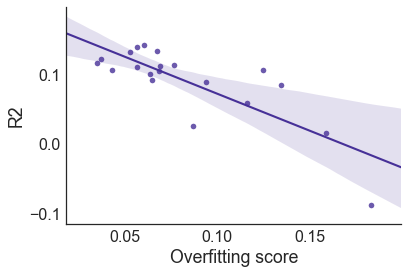

In [182]:
ax = seaborn.regplot(data=embedding_not_averaged_results, x='OS', y='R2', color=colors.dark_blue)
ax.set(xlabel='Overfitting score')
seaborn.despine()

# Experiments with COEMBEDDINGS

In [183]:
COEMBEDDINGS_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-18-20',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-18-28',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-18-46',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-18-57',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-19-07',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-19-41',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-19-51',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-20-16',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-20-25',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-20-49',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-20-59',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-21-10',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-21-20',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-21-29',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-21-54',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-22-04',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-22-14',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-22-28',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-22-42',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-22-56',
'/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-28-23-07',
]

In [184]:
co_performances = read_performances(COEMBEDDINGS_EXPERIMENTS_DIRS)

In [185]:
co_overfitting_score = get_overfitting_score(co_performances).set_index('Experiment')
co_overfitting_score

,OS
Experiment,
19-05-28-18-20,0.033732
19-05-28-18-28,0.064179
19-05-28-18-46,0.032377
19-05-28-18-57,0.029806
19-05-28-19-07,0.085603
19-05-28-19-41,0.027823
19-05-28-19-51,0.089259
19-05-28-20-16,0.032852
19-05-28-20-25,0.155762


In [175]:
graphic_performances({experiment: d for experiment, d in performances.items()
                      if co_overfitting_score.loc[experiment.split('/')[-1]].OS > 0.1})

KeyError: 'the label [19-05-26-18-53] is not in the [index]'

## Performance metrics not averaged by sequence

In [186]:
co_not_averaged_results = get_not_averaged_metrics(COEMBEDDINGS_EXPERIMENTS_DIRS).merge(
    co_overfitting_score.reset_index()).sort_values('Experiment')
co_not_averaged_results

,Experiment,AUC,RMSE,Accuracy,R2,OS
20,19-05-28-18-20,0.724460,0.447923,0.695460,0.108543,0.033732
19,19-05-28-18-28,0.734288,0.455844,0.705194,0.074412,0.064179
18,19-05-28-18-46,0.727310,0.448834,0.701543,0.106484,0.032377
17,19-05-28-18-57,0.722887,0.446064,0.692732,0.119029,0.029806
16,19-05-28-19-07,0.740014,0.456691,0.706371,0.089079,0.085603
15,19-05-28-19-41,0.720599,0.449458,0.690341,0.108144,0.027823
14,19-05-28-19-51,0.734286,0.454540,0.700014,0.086532,0.089259
13,19-05-28-20-16,0.714164,0.449257,0.689562,0.106302,0.032852
12,19-05-28-20-25,0.731010,0.468691,0.699934,0.042270,0.155762
11,19-05-28-20-49,0.730471,0.451509,0.701952,0.090330,0.049010


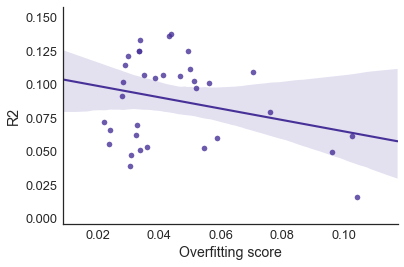

In [124]:
ax = seaborn.regplot(data=co_not_averaged_results, x='OS', y='R2', color=colors.dark_blue)
ax.set(xlabel='Overfitting score')
seaborn.despine()

## Performance according to position in sequence

In [103]:
def get_all_position_metrics(true, predicted):
    """Gets average metrics according to position of the prediction in the sequence"""
    results = []
    for true_sequence, predicted_sequence in zip(true, predicted):
        for index, (true_label, predicted_label) in enumerate(zip(true_sequence, predicted_sequence)):
            results.append([index, (numpy.abs(true_label - predicted_label))**0.5, int(true_label == round(predicted_label))])
    return pandas.DataFrame(results, columns=['Sequence position', 'SquaredError', 'Accuracy'])

In [105]:
test_prediction_file = '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/19-05-26-17-18/predictions_run0.p'

with open(test_prediction_file, 'rb') as prediction_file:
    true, predicted = pickle.load(prediction_file)

position_metrics = get_all_position_metrics(true, predicted)

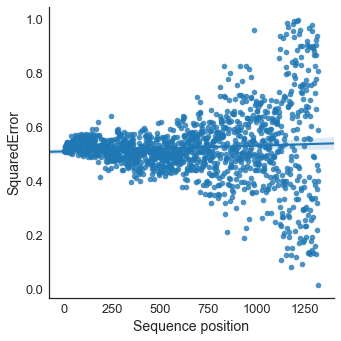

In [106]:
seaborn.lmplot(x='Sequence position', y='SquaredError',
               data=position_metrics.groupby('Sequence position').mean().reset_index())

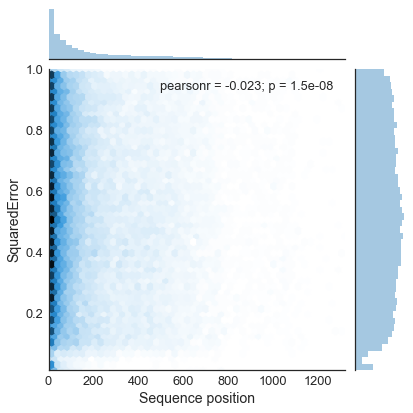

In [110]:
seaborn.jointplot(data=position_metrics, x='Sequence position', y='SquaredError', kind='hex')

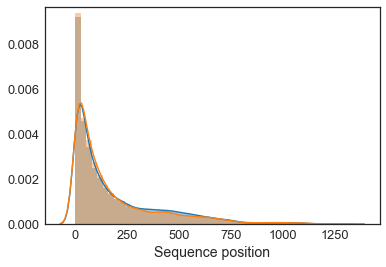

In [114]:
seaborn.distplot(position_metrics[position_metrics.Accuracy == 1]['Sequence position'])
seaborn.distplot(position_metrics[position_metrics.Accuracy == 0]['Sequence position'])

In [144]:
general_os = pandas.concat([embedding_not_averaged_results, lstm_metrics, co_not_averaged_results])
general_os.loc[:,'outlier'] = general_os.OS > 0.09

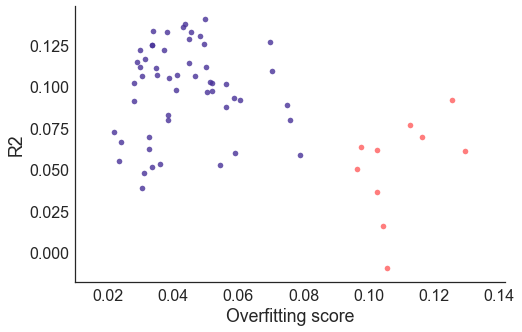

In [158]:
my_pal = {False: colors.dark_blue, True: colors.red}
ax = seaborn.lmplot(data=general_os, legend=False, palette=my_pal,
                     x='OS', y='R2', fit_reg=False, hue='outlier', aspect=1.5)
ax.set(xlabel='Overfitting score')
seaborn.despine()